<img src="files/resources/ml.jpg">

<img src="files/resources/me.jpg">

Siamese network with triplet loss in python from scratch.
NG
(unzip data.zip before running)

In [1]:
import numpy as np
import cv2
import math
from os import listdir
from os.path import isfile, join
import random as r
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
vecLog = np.vectorize(math.log)

The following two functions lead to create two type of dataset:
One for the classification task
One for triplet loss training

In [2]:
def create_dataset_classification(path):
    files={}
    labels={}
    id=0
    for label in listdir(path):
        labelPath = join(path, label)
        labeledImages = listdir(labelPath)
        for labeledImage in labeledImages:
            imagePath=join(labelPath, labeledImage)
            files[id]=imagePath
            labels[id]=label
            id = id + 1
    return (files,labels)

def create_dataset_verification(path):
    triplets=[]
    labels=listdir(path)
    nLabels=labels
    labeledFiles={}

    for label in labels:
        labelPath = join(path, label)
        images = listdir(labelPath)
        labeledFiles[label]=images

    for label in labels:
        positives = labeledFiles[label]
        nLabels.remove(label)
        for anchor in positives:
            randomPositive = r.choice(positives)
            randomNegativeLabel = r.choice(nLabels)
            randomNegativeItems=labeledFiles[randomNegativeLabel]
            randomNegative = r.choice(randomNegativeItems)

            a = join(path, label,anchor)
            b = join(path, label,randomPositive)
            c = join(path, randomNegativeLabel,randomNegative)

            triplets.append((a,b,c))

    return triplets

load_image: read and load a single image from the filesystem, then the image is vectorized in row-major order.
<img src="files/resources/rm.jpg">

In [3]:
def load_image(path):
    img = cv2.imread(path,0)
    img=(img.flatten()/255)
    img=img.reshape([1,img.size])
    return (img) #image as w*h image flattened in row-major order

Neural network variables. Each layer is made by:
(layers) ID
(layer_weight) WEIGHTS
(layer_weight_gradient_cache) dL/dw
(layer_bias) BIAS
(layer_bias_gradient_cache) dL/db
(layer_input_cache) the input of the layer
(layer_forward_function) how to calculate the output given the input
(layer_backward_function) how to calculate dL/dI 

In [4]:
layers=[]
layer_weight={}
layer_weight_gradient_cache={}
layer_bias={}
layer_bias_gradient_cache={}
layer_input_cache={}
layer_forward_function={}
layer_backward_function={}

Activation layer creation.
The activation layer does not have weigths and bias, just the ID and the computation functions are setted.

In [5]:
def create_activation_layer(id,size,forward_function,backward_function):
    layers.append(id)
    layer_forward_function[id]  = forward_function
    layer_backward_function[id] = backward_function

How the activation function is computed during the forward and backword pass.
<img src="files/resources/lr.jpg">

In [6]:
def forward_leaky_relu(id,input):
    layer_input_cache[id] = input
    output = np.vectorize(leaky_relu)(input,0.01)
    return output

def backward_leaky_relu(id,delta):
    cached_input=layer_input_cache[id]
    new_delta = np.vectorize(leaky_relu_derivative)(cached_input,0.01)
    return delta*new_delta

def leaky_relu_derivative(x,alpha):
        if(x>0):
            return 1
        else:
            return alpha

def leaky_relu(x,alpha):
    if(x>0):
        return x
    else:
        return x*alpha

Also for softmax activation.
I need softmax for a fast pretrain.

In [7]:
def forward_softmax(id,input):
    layer_input_cache[id] = input
    z = np.vectorize(math.exp)(input).sum()
    output = np.vectorize(softmax)(input,z)
    return output

def backward_softmax(id,delta):
    return delta

def softmax(x,z):
    return math.exp(x)/z

Fully connected layer creation.

In [8]:
def create_fullyconnected_layer(id, input_size, output_size, init_function, forward_function, backward_function):
    w = init_function(input_size*output_size)
    w = w.reshape([input_size, output_size])
    b = init_function(output_size)
    b = np.asarray(b)
    w = np.asarray(w)
    layer_weight[id] = w
    layer_bias[id] = b
    layers.append(id)
    layer_forward_function[id] = forward_function
    layer_backward_function[id] = backward_function

<img src="files/resources/fcf.jpg">

In [9]:
def forward_fullyconnected(id,input):
    layer_input_cache[id] = input
    output = np.matmul(input,layer_weight[id]) + layer_bias[id]
    return output

<img src="files/resources/fcb.jpg">

In [10]:
def backward_fullyconnected(id,delta):
    cached_input=layer_input_cache[id]
    w=layer_weight[id]
    b=layer_bias[id]

    # df/dx * delta ( df/dx = w )
    new_delta=np.transpose(np.matmul(w,np.transpose(delta)))

    # df/dw * delta ( df/dw = x )
    if id in layer_weight_gradient_cache:
        layer_weight_gradient_cache[id] = layer_weight_gradient_cache[id] + np.matmul(np.transpose(cached_input),delta)
    else:
        layer_weight_gradient_cache[id] = np.matmul(np.transpose(cached_input),delta)

    # df/db * delta ( df/db = 1 )
    if id in layer_bias_gradient_cache:
        layer_bias_gradient_cache[id] = layer_bias_gradient_cache[id] + 1*delta
    else:
        layer_bias_gradient_cache[id] = 1*delta

    return new_delta

Weights initialization.

In [11]:
def compute_initialization(size , initialization_function):
    data = np.empty([size,1])
    map(initialization_function, numbers)
    return data

def relu_initializer( size ):
    sigma = math.sqrt( 2.0/size )
    mu = 0
    return np.random.normal(mu, sigma, size)

<img src="files/resources/nnfa.jpg">

In [12]:
def compute_forward_pass(input):
    data=input
    for layer in layers:
        data=layer_forward_function[layer](layer,data)
    return data

<img src="files/resources/nncba.jpg">

In [13]:
def compute_backward_pass(delta):
    data=delta
    for layer in np.flip(layers):
        data=layer_backward_function[layer](layer,data)

<img src="files/resources/nnvu.jpg">

In [14]:
def compute_params_update(learning_rate):
    for layer in layers:
        if layer in layer_weight_gradient_cache:
            update_value = -learning_rate*(layer_weight_gradient_cache[layer])
            layer_weight[layer] = layer_weight[layer] + update_value
            layer_weight_gradient_cache.pop(layer)
        if layer in layer_bias_gradient_cache:
            update_value = -learning_rate*(layer_bias_gradient_cache[layer])
            layer_bias[layer] = layer_bias[layer] + update_value
            layer_bias_gradient_cache.pop(layer)

<img src="files/resources/tlta.jpg">

In [15]:
def compute_triplet_backward_pass(anchor,positive,negative,batch_size):
    margin=0.2
    anchor_image=load_image(anchor)
    positive_image=load_image(positive)
    negative_image=load_image(negative)

    anchor_out = compute_forward_pass(anchor_image)
    positive_out = compute_forward_pass(positive_image)
    negative_out = compute_forward_pass(negative_image)

    f = np.square(anchor_out-positive_out)-np.square(anchor_out-negative_out) + margin
    lossVec = np.maximum(f,0)
    mask = (f > 0)*1

    dLda = 2*(negative_out-positive_out)*mask/batch_size
    dLdp = 2*(positive_out-anchor_out)*mask/batch_size
    dLdn = 2*(anchor_out-negative_out)*mask/batch_size

    compute_forward_pass(anchor_image)
    compute_backward_pass(dLda)

    compute_forward_pass(positive_image)
    compute_backward_pass(dLdp)

    compute_forward_pass(negative_image)
    compute_backward_pass(dLdn)

    loss = lossVec.sum()/batch_size
    return loss

workspace

In [16]:
image_input_size = 28*28
hidden_layer_size = 48
hidden_layer_size_half = 24
num_labels = 10
learning_rate = 0.05

<img src="files/resources/nna.jpg">

In [17]:
create_fullyconnected_layer('fc1',image_input_size,hidden_layer_size,relu_initializer,forward_fullyconnected,backward_fullyconnected)
create_activation_layer('fc1_relu',hidden_layer_size,forward_leaky_relu,backward_leaky_relu)
create_fullyconnected_layer('fc2',hidden_layer_size,hidden_layer_size_half,relu_initializer,forward_fullyconnected,backward_fullyconnected)
create_activation_layer('fc2_relu',hidden_layer_size_half,forward_leaky_relu,backward_leaky_relu)
create_fullyconnected_layer('fc3',hidden_layer_size_half,num_labels,relu_initializer,forward_fullyconnected,backward_fullyconnected)
create_activation_layer('softmax',num_labels,forward_softmax,backward_softmax)

Start classification training

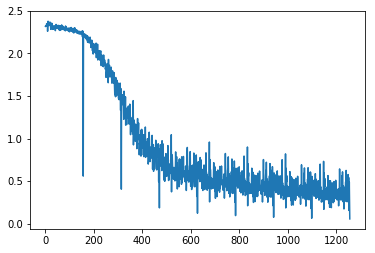

In [18]:
(inputs,labels) = create_dataset_classification("data/mnist/train")
dataset_size = len(inputs)
selected = r.sample(range(0, dataset_size), int(dataset_size))
batch_size = 64
batches = [selected[n:n+batch_size] for n in range(0, len(selected), batch_size)]

classification_score=[]
for epoch in range(0,8):
#     print("epoch " + str(epoch))
    for batch in batches:
        res = 0
        for example in batch:
            input_path=inputs[example]
            label_index=int(labels[example])
            label=np.zeros((num_labels))
            label[label_index]=1

            input = load_image(input_path)
            net_outut = compute_forward_pass(input)

            loss = -1*np.sum(label*vecLog(net_outut))/batch_size
            res = res + loss

            delta = (net_outut-label)/batch_size
            compute_backward_pass(delta)
#         print("score " + str(res))
        classification_score.append(res)
        compute_params_update(learning_rate)
plt.plot(classification_score)
plt.show()

Removing softmax for triplet loss training.

In [19]:
print("before removing softmax: " + str(layers))
layers.remove("softmax")
print("after removing  softmax: " + str(layers))

before removing softmax: ['fc1', 'fc1_relu', 'fc2', 'fc2_relu', 'fc3', 'softmax']
after removing  softmax: ['fc1', 'fc1_relu', 'fc2', 'fc2_relu', 'fc3']


Start triplet loss training

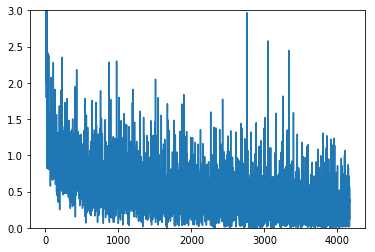

In [20]:
learning_rate=0.01
triplet_score=[]
for epoch in range(0,10):
    dataset = create_dataset_verification("data/mnist/train")
    r.shuffle(dataset)
    selected = dataset
    batch_size = 12
    batches = [selected[n:n+batch_size] for n in range(0, len(selected), batch_size)]
    # print("epoch " + str(epoch))
    for batch in batches:
        loss = 0
        for triplet in batch:
            (anchor,positive,negative)=triplet
            loss = loss + compute_triplet_backward_pass(anchor,positive,negative,batch_size)
        compute_params_update(learning_rate)
#         print("loss " + str(loss))
        triplet_score.append(loss)

plt.plot(triplet_score)
plt.ylim((0, 3))  
plt.show()

Testing the net with few examples

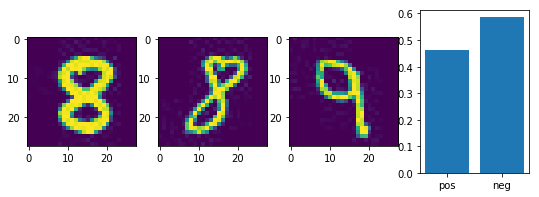

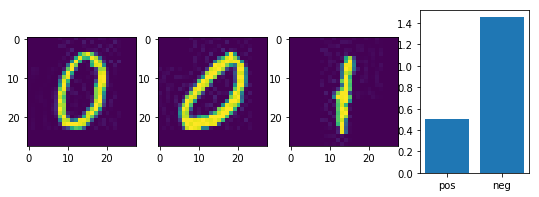

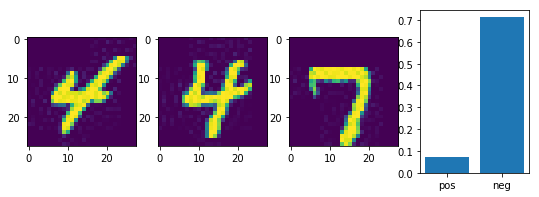

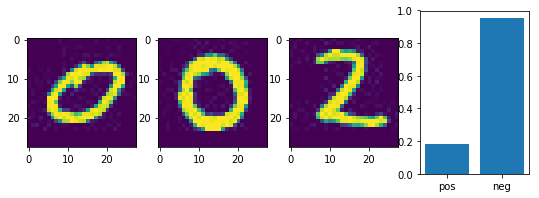

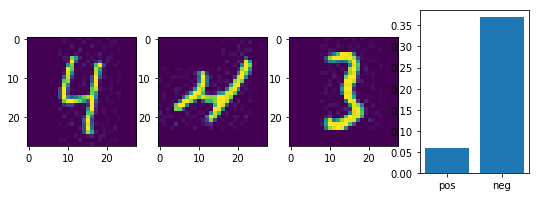

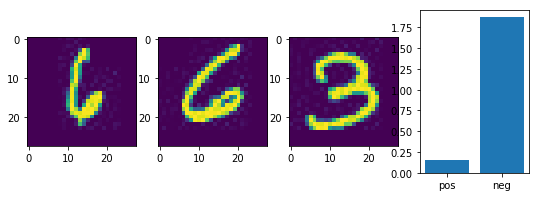

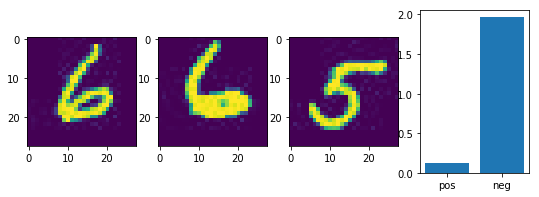

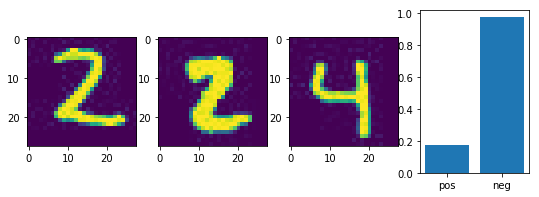

In [21]:
test_num=8
test_examples=create_dataset_verification("data/mnist/test")
num=len(test_examples)
selected = r.sample(range(1, num), int(test_num))
for triplet in selected:
    image_embeddings=[]
    (anchor,positive,negative)=test_examples[triplet]
    anchor_out = compute_forward_pass(load_image(anchor))
    positive_out = compute_forward_pass(load_image(positive))
    negative_out = compute_forward_pass(load_image(negative))
    dist_positive = np.linalg.norm(anchor_out/np.linalg.norm(anchor_out)-positive_out/np.linalg.norm(positive_out))
    dist_negative = np.linalg.norm(anchor_out/np.linalg.norm(anchor_out)-negative_out/np.linalg.norm(negative_out))
    fig, axs = plt.subplots(1, 4, figsize=(9, 3), sharey=True)
    plt.subplot(141)
    plt.imshow(mpimg.imread(anchor))
    plt.subplot(142)
    plt.imshow(mpimg.imread(positive))
    plt.subplot(143)
    plt.imshow(mpimg.imread(negative))
    plt.subplot(144)
    plt.bar([1,2],height= [dist_positive,dist_negative])
    plt.xticks([1,2], ['pos','neg'])